# Total COVID-19 daily cases
Script produced by [Laurent Lessard](https://laurentlessard.com)

---

### Import data from JHU CSSE

In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

import datetime
from matplotlib.dates import DateFormatter

mpl.rcParams['figure.dpi'] = 120

# get country data
url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
df_raw = pd.read_csv(url)

# get country populations
url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/UID_ISO_FIPS_LookUp_Table.csv"
df_pop = pd.read_csv(url, index_col="Combined_Key", usecols=["Combined_Key", "Population"]).Population

### Reformat data into convenient form

In [2]:
colnames = df_raw.columns

# aggregate by region
df = df_raw.pivot_table(index='Country/Region',values=colnames[4:],aggfunc=sum)

# make countries columns rather than rows
df = df.T

# make the index a datetime object
df = df.reindex( pd.to_datetime(df.index) )

# sort the dates/times
df.sort_index(inplace=True)

# record the latest date
latest_date = df.index[-1].strftime("%a %b %d, %Y")
print(latest_date)

Sun Jul 19, 2020


### List of countries with the most confirmed cases

In [3]:
cases_total = df.max() * 1.0
for name,cases in cases_total.items():
    cases_total[name] /= df_pop[name]
cases_sorted = cases_total.sort_values(ascending=False)
cases_sorted.head(15)

Country/Region
Qatar         0.037017
Bahrain       0.021405
San Marino    0.020596
Chile         0.017311
Holy See      0.014833
Kuwait        0.013863
Oman          0.013054
Panama        0.012392
Armenia       0.011770
US            0.011453
Andorra       0.011389
Peru          0.010724
Brazil        0.009872
Luxembourg    0.008954
Singapore     0.008190
dtype: float64

### List of countries with the most daily cases

In [4]:
daily_cases_total = df.diff().max() * 1.0
for name,cases in daily_cases_total.items():
    daily_cases_total[name] /= df_pop[name]
daily_cases_sorted = daily_cases_total.sort_values(ascending=False)
daily_cases_sorted.head(20)

Country/Region
Holy See                 0.003708
Chile                    0.001893
Kyrgyzstan               0.001763
San Marino               0.001591
Montenegro               0.001080
Andorra                  0.001022
Kazakhstan               0.000999
Qatar                    0.000817
Equatorial Guinea        0.000763
Sao Tome and Principe    0.000689
Ecuador                  0.000654
Liechtenstein            0.000551
Seychelles               0.000508
Bahrain                  0.000462
Oman                     0.000424
France                   0.000411
Antigua and Barbuda      0.000398
Kosovo                   0.000377
Luxembourg               0.000374
Panama                   0.000357
dtype: float64

In [9]:
# Country group for European Union
idx_EUK = ["Austria", "Belgium", "Bulgaria", "Croatia", "Cyprus", "Czechia", "Denmark",
          "Estonia", "Finland", "France", "Germany", "Greece", "Hungary", "Ireland",
          "Italy", "Latvia", "Lithuania", "Luxembourg", "Malta", "Netherlands", "Poland",
          "Portugal", "Romania", "Slovakia", "Slovenia", "Spain", "Sweden", "United Kingdom"]
df["EU + UK"] = df[idx_EUK].sum(axis="columns")
df_pop["EU + UK"] = df_pop[idx_EUK].sum()


# Country group for South America
idx_SA = ["Argentina", "Bolivia", "Brazil", "Chile", "Colombia", "Ecuador",
          "Guyana", "Paraguay", "Peru", "Suriname", "Uruguay", "Venezuela"]
df["South America"] = df[idx_SA].sum(axis="columns")
df_pop["South America"] = df_pop[idx_SA].sum()

### Plot daily confirmed cases

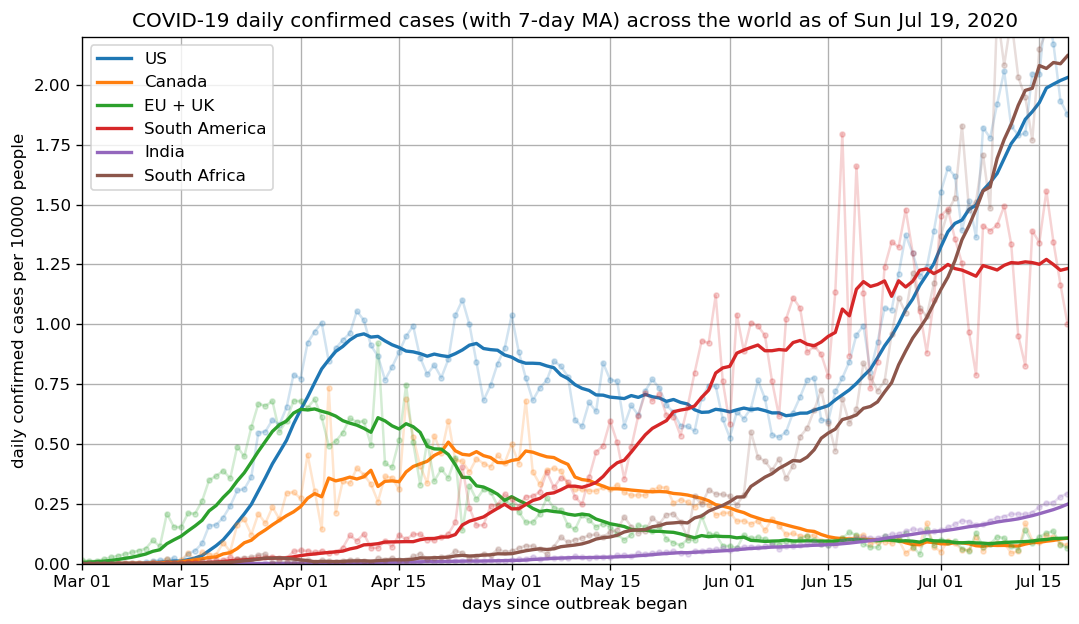

In [13]:
plt.figure(figsize=(9,5))
ax = plt.gca()

# selected countries
countries = ['US','Canada','EU + UK','South America', 'India', 'South Africa']
# countries = cases_sorted[:6].index
min_cases = 1
pop_scale = 10000

# shift data so that index corresponds to days since min_cases cases.
# shifted_data = shift_data( countries, min_cases )
# data_len = max([len(dat) for dat in shifted_data])

# xmax = data_len

for name in countries:
    data = df[name]
    color = next(ax._get_lines.prop_cycler)['color']
    population = df_pop[name]
    plt.plot( data.diff() / population * pop_scale, marker=".", label=None, color=color, alpha=0.2 )
    plt.plot( data.diff().rolling(7).mean() / population * pop_scale, marker="", label=name, color=color, linewidth=2 )

# make plot
ax.set_title("COVID-19 daily confirmed cases (with 7-day MA) across the world as of %s" % latest_date)
ax.legend(loc="upper left")
ax.set_xlabel("days since outbreak began" )
ax.set_ylabel(f"daily confirmed cases per {pop_scale} people")
ax.grid()

date_format = "%b %d"
ax.xaxis.set_major_formatter(DateFormatter(date_format))
ax.autoscale(enable=True, axis='x', tight=True)
date_start = datetime.date(2020, 3, 1)
# date_end   = datetime.date(2020, 10, 1)
plt.xlim(xmin=date_start)

plt.ylim(ymin=0,ymax=2.2)    
plt.tight_layout(pad=0)

plt.savefig("figures/world_daily_cases.png")

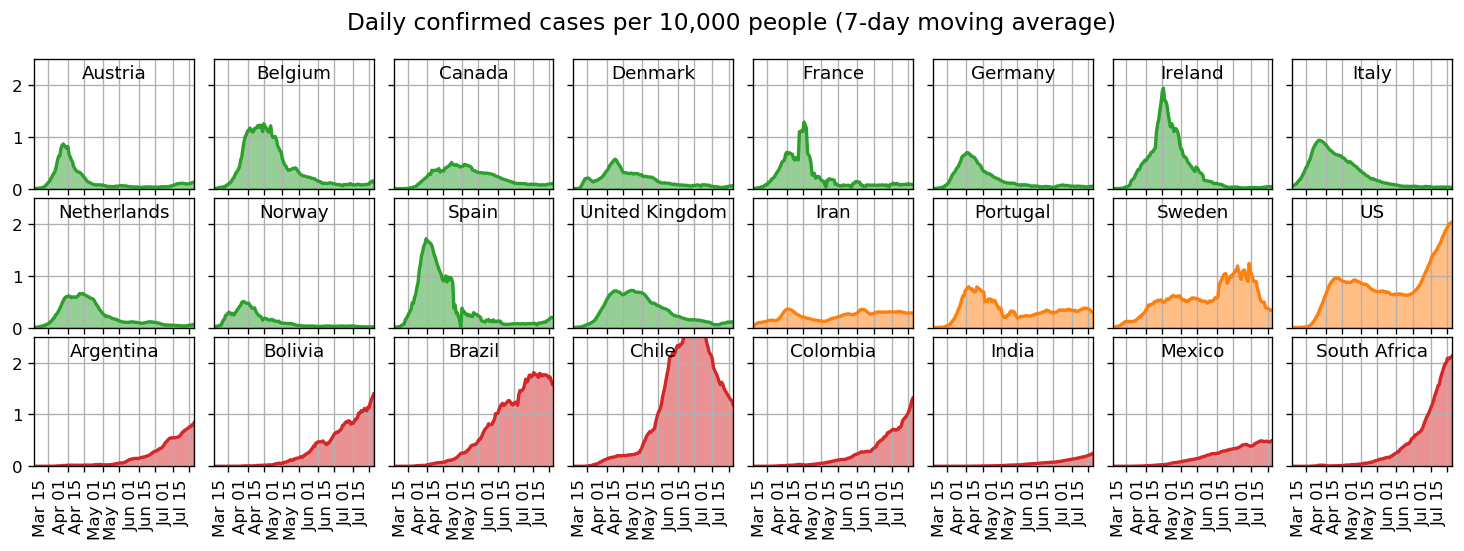

In [14]:
fig,axs = plt.subplots(3,8, figsize=(12,4), sharey=True, sharex=True)

# curves that go up and down (13)
cat1 = ['Austria','Belgium','Canada','Denmark','France','Germany','Ireland','Italy','Netherlands','Norway','Spain','United Kingdom'] # 'Finland', 'Estonia'

# curves that flattened but now are growing again (3)
cat2 = ['Iran','Portugal','Sweden','US']

# curves that just go straight up (5)
cat3 = ['Argentina','Bolivia','Brazil','Chile','Colombia','India','Mexico','South Africa']

pop_scale = 10000

for ix,name in enumerate(cat1+cat2+cat3):
    if ix < len(cat1):
        col = "C2"
    elif ix < len(cat1)+len(cat2):
        col = "C1"
    else:
        col = "C3"
    ax = axs.reshape(-1)[ix]
    data = df[name]
    population = df_pop[name]
    ax.fill_between( x=data.index, y1=data.diff().rolling(7).mean() / population * pop_scale, alpha=0.5, color=col )
    ax.plot( data.diff().rolling(7).mean() / population * pop_scale, label=name, linewidth=2, color=col )
    txt = ax.text(.5,.85, name,
            horizontalalignment='center',
            transform=ax.transAxes,
            fontsize=11)
    ax.grid()
    date_format = "%b %d"
    ax.xaxis.set_major_formatter(DateFormatter(date_format))
    ax.autoscale(enable=True, axis='x', tight=True)
    date_start = datetime.date(2020, 3, 3)
#     date_end   = datetime.date(2020, 7, 1)
    ax.set_xlim(xmin=date_start) #, xmax=date_end)
    ax.set_ylim(ymin=0,ymax=2.5)

fig.autofmt_xdate(rotation=90)
my_suptitle = fig.suptitle("Daily confirmed cases per 10,000 people (7-day moving average)", fontsize=14, y=1.1)

plt.tight_layout(pad=0)
plt.savefig("figures/world_daily_cases_breakdown.png", dpi=fig.dpi, bbox_inches='tight', bbox_extra_artists=[my_suptitle])